Model Mean Absolute Percentage Error: 9.575787993330035%
R-squared value: 0.9114109610571538


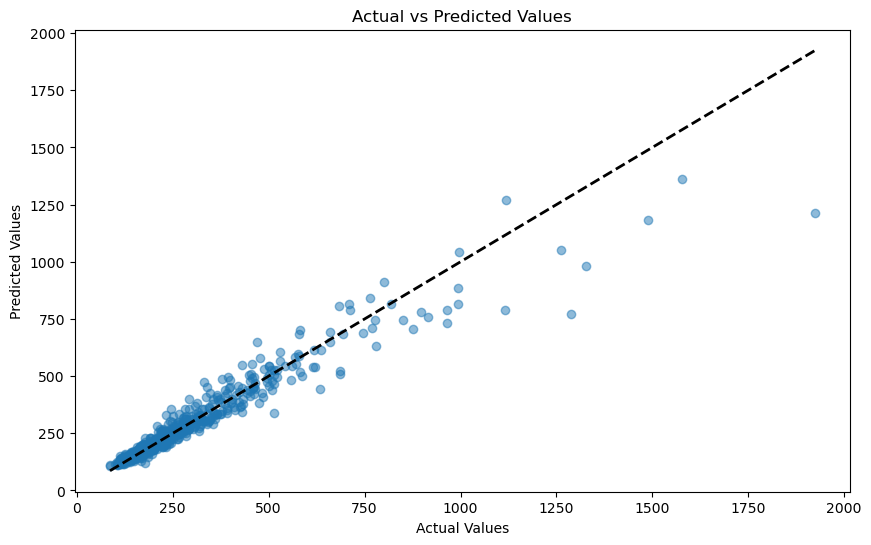

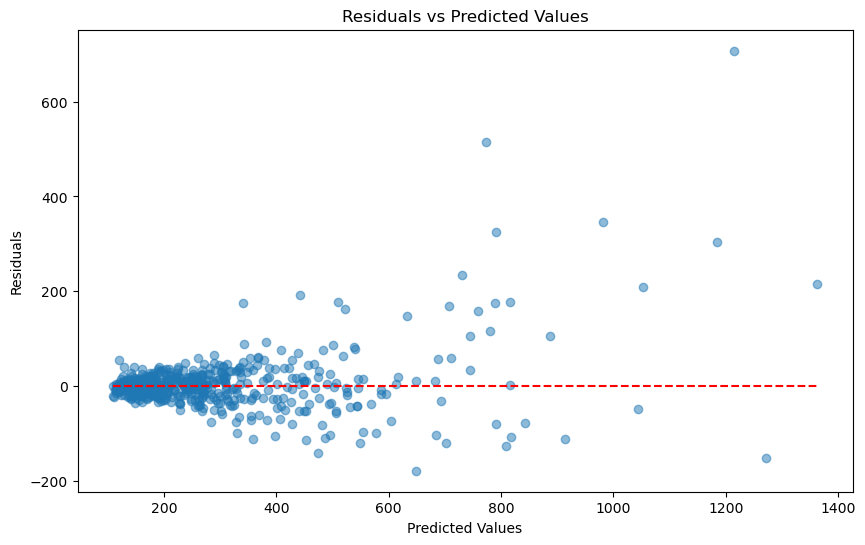

Feature Importances:
Artist Reputation: 0.6546668970197528
Weight: 0.08659263122000001
Price Of Sculpture: 0.07516296337369963
Height: 0.06947653310312443
Base Shipping Price: 0.06565884694373056
Width: 0.013216842442893806
Installation Included_No: 0.005579044955107153
Installation Included_Yes: 0.004570598918112511
Express Shipment_No: 0.004234897132792413
Express Shipment_Yes: 0.004158981374550967
Customer Information_Working Class: 0.0036455042086837564
Customer Information_Wealthy: 0.002599174120158636
Transport_Waterways: 0.001873793150047183
International_Yes: 0.00179557505737184
International_No: 0.0017121222040239932
Material_Marble: 0.0010723465286476344
Material_Stone: 0.0010281989568662925
Transport_Airways: 0.0007113002068828003
Fragile_No: 0.000532872010860884
Remote Location_Yes: 0.0004511306272543056
Remote Location_No: 0.0003382356592101592
Material_Clay: 0.0003288368819581609
Fragile_Yes: 0.00023758906270960353
Material_Aluminium: 0.0001543827333185854
Material_Brass:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_percentage_error, r2_score

# Load the data
file_path = 'train.csv'
data = pd.read_csv(file_path)

# Outlier Removal
exclude_columns = ['Cost', 'Customer Id', 'Artist Name', 'Scheduled Date', 'Delivery Date', 'Customer Location']
numeric_cols = data.select_dtypes(include=[np.number]).columns
features_to_check = [col for col in numeric_cols if col not in exclude_columns]

for feature in features_to_check:
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data[feature] >= lower_bound) & (data[feature] <= upper_bound)]


# Change the data from negative to positive
data['Cost'] = data['Cost'].abs()
# Selecting features and target variable
X = data.drop(columns=['Cost', 'Customer Id', 'Artist Name', 'Scheduled Date', 'Delivery Date', 'Customer Location'])
y = data['Cost']

# Apply a logarithmic transformation to the target variable
y_transformed = np.log1p(y)

# Handling categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns

# Creating transformers
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())  # Standardizing numerical features
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundling transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Modeling pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=0))])

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=0)

# Training the model
model.fit(X_train, y_train)

# Making predictions and evaluating the model
y_pred_transformed = model.predict(X_test)
y_pred = np.expm1(y_pred_transformed)
y_test_original = np.expm1(y_test)

# Calculate MAPE using the original scale of the target
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100
print(f"Model Mean Absolute Percentage Error: {mape}%")

# R-squared calculation
r2 = r2_score(y_test_original, y_pred)
print(f"R-squared value: {r2}")

# Plotting Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, y_pred, alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([y_test_original.min(), y_test_original.max()], [y_test_original.min(), y_test_original.max()], 'k--', lw=2)
plt.show()

# Plotting Residuals
residuals = y_test_original - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='red', linestyles='--')
plt.show()

# Extract feature importances
feature_importances = model.named_steps['regressor'].feature_importances_

# Getting feature names after one-hot encoding
ohe_feature_names = model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = numerical_cols.tolist() + ohe_feature_names.tolist()

# Pairing feature names with their importance scores
feature_importance_dict = dict(zip(all_feature_names, feature_importances))

# Sorting features by importance
sorted_importances = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

# Displaying feature importances
print("Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")

# Load the training data
train_file_path = 'train.csv'
data = pd.read_csv(train_file_path)

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_transformed, test_size=0.2, random_state=0)

# Modeling pipeline with Linear Regression
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Training the model
model.fit(X_train, y_train)

# Load the test data
test_file_path = 'test.csv'
test_data = pd.read_csv(test_file_path)

# Ensure that test data has the same feature columns as X used for training
test_X = test_data[X.columns]

# Making predictions on the test data
test_y_pred_transformed = model.predict(test_X)

# Optional: Inspect the predicted values
print("Max log-scale prediction:", max(test_y_pred_transformed))

# Clipping predictions to a maximum value
MAX_LOG_SCALE_PREDICTION = 10
test_y_pred_transformed_clipped = np.clip(test_y_pred_transformed, None, MAX_LOG_SCALE_PREDICTION)

# Apply expm1 transformation with clipped values
test_y_pred = np.expm1(test_y_pred_transformed_clipped)

# Creating a DataFrame for the predictions
predictions = pd.DataFrame({'Customer Id': test_data['Customer Id'], 'Predicted Cost': test_y_pred})

# Save the predictions to a new CSV file
predictions.to_csv('predictions.csv', index=False)

# Displaying first few predictions
print(predictions.head())